In [9]:
import pandas as pd
import numpy as np
# import ydata_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import json
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## 공통 전처리

In [10]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# data set load
DATA_PATH = '/opt/ml/input/data'
train_path = os.path.join(DATA_PATH, 'train_data.csv')
test_path = os.path.join(DATA_PATH, 'test_data.csv')

train_df = pd.read_csv(train_path, dtype=dtype, parse_dates=['Timestamp'])
test_df = pd.read_csv(test_path, dtype=dtype, parse_dates=['Timestamp'])

CPU times: user 2.76 s, sys: 208 ms, total: 2.97 s
Wall time: 2.97 s


In [11]:
# tain data에 elapsed time 추가
diff_train = train_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)
diff_train = diff_train['Timestamp'].apply(lambda x: x.total_seconds())
train_df['elapsed'] = diff_train

# test data에 elapsed time 추가
diff_test = test_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)
diff_test = diff_test['Timestamp'].apply(lambda x: x.total_seconds())
test_df['elapsed'] = diff_test

# answerCode가 -1인 data 제거 (예측해야 하는 값)
test_df = test_df[test_df['answerCode'] != -1]
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

df = pd.concat([train_df, test_df])

In [12]:
import pytz

# 한국 기준으로 Timestamp 변경
kst = pytz.timezone('Asia/Seoul')
df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert(kst)

### Feature Engineering
testID의 1~3번째 자리를 이용한 대분류인 testCode 생성

In [13]:
df['testCode'] = df['testId'].apply(lambda x : x[1:4])

#testCode 1~9의 정수형 값으로 변환
df['testCode'] = df['testCode'].astype('int') //10

In [14]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6
...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4


## Overview

+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다. 이 중 train data에는 6698명이, test data에는 744명이 존재합니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.

In [15]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 7442
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.46%
KnowledgeTag     : 912
--------------------------


0과 1의 데이터 분포 파악

Text(0.5, 1.0, 'Distribution of answerCode=0')

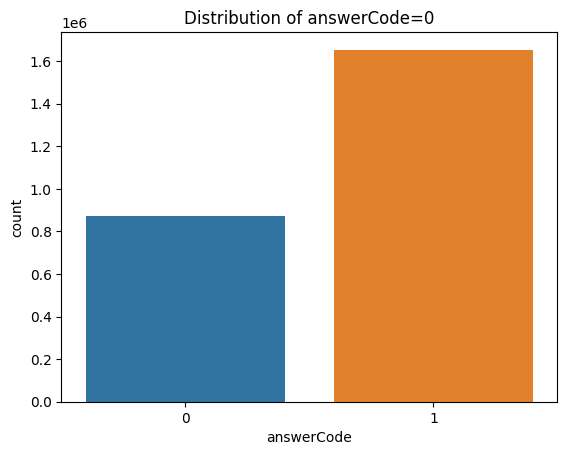

In [16]:
df.answerCode.value_counts()
sns.countplot(data=df, x='answerCode').set_title('Distribution of answerCode=0')

assessmentItemID의 맨 앞자리가 A로 시작하는지 확인

In [17]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

testID의 맨 앞자리가 A로 시작하는지 확인

In [18]:
df['testId'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

testID의 4~6번째 자리가 '000'인지 확인

In [19]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

assessmentItemID가 testID에 맞게 잘 이루어져있는지 확인

In [20]:
(df['assessmentItemID'].apply(lambda x: x[1:7]) != df['testId'].apply(lambda x: x[1:4] + x[7:])).sum()

0

### 사용되는 함수

In [21]:
#정답률을 빠르게 구하기 위해 함수 정의
def percentile(s):
    return np.sum(s) / len(s)

## 사용자 분석

In [22]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,7442.000000,7442.000000
mean,339.418973,0.628749
std,321.465413,0.159608
min,9.000000,0.000000
25%,78.000000,0.526782
50%,232.500000,0.651923
75%,519.000000,0.750728
max,1860.000000,1.000000


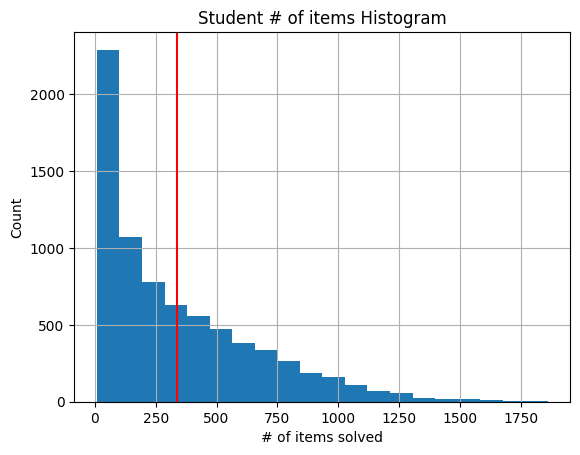

In [23]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
# ax.grid(b=True)

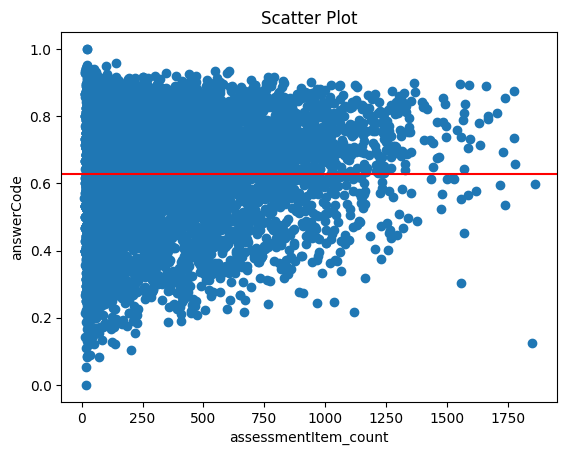

In [24]:
plt.scatter(stu_groupby['assessmentItemID'], stu_groupby['answerCode'])
plt.axhline(stu_groupby['answerCode'].mean(), color='red')
plt.xlabel('assessmentItem_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

## 문제 별 정답률 분석

In [25]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,267.183838,0.654468
std,79.648425,0.195183
min,46.000000,0.043333
25%,250.000000,0.504000
50%,250.000000,0.666667
75%,300.000000,0.820000
max,500.000000,0.996667


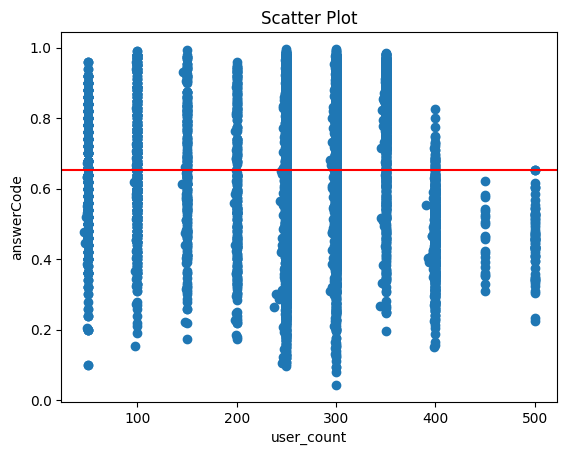

In [26]:
plt.scatter(prob_groupby['userID'], prob_groupby['answerCode'])
plt.axhline(prob_groupby['answerCode'].mean(), color='red')
plt.xlabel('user_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

350명 이하의 유저가 푼 문제들은 대체로 정답률이 골고루 분포함 \
350명 이상이 푼 문제의 정답률의 범위가 줄어듬

## 시험지 별 정답률 분석

In [27]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    # 'assessmentItemID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1643.432661,0.668194
std,592.144998,0.138739
min,200.000000,0.330625
25%,1499.000000,0.561781
50%,1500.000000,0.681490
75%,1794.000000,0.778731
max,4398.000000,0.956638


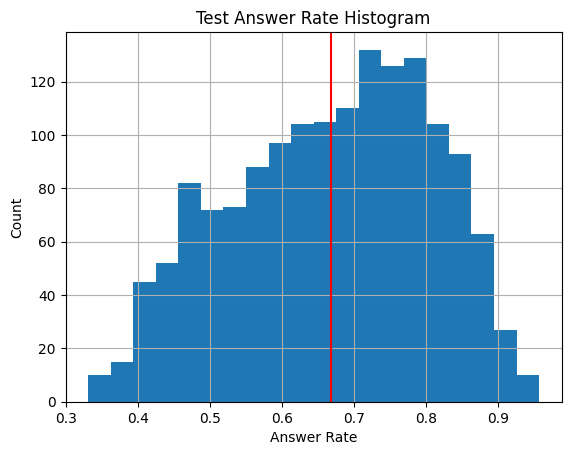

In [28]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
# ax.grid(b=True)

## 문항의 고유 태그 별 정답률 분석

In [29]:
know_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    # 'assessmentItemID': 'count',
    # 'testId': 'count',
    'answerCode': percentile
})
know_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2769.688596,0.616113
std,1931.512673,0.147971
min,50.000000,0.176000
25%,1133.750000,0.500000
50%,2499.000000,0.601969
75%,4500.000000,0.741919
max,14350.000000,0.972857


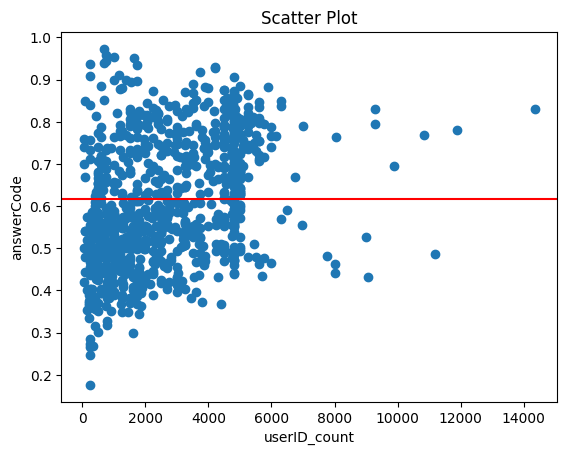

In [30]:
plt.scatter(know_groupby['userID'], know_groupby['answerCode'])
plt.axhline(know_groupby['answerCode'].mean(), color='red')
plt.xlabel('userID_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

### ydata_profiling

In [31]:
"""profile = df.profile_report()
profile"""

In [32]:
# profile.to_widgets()

In [33]:
# profile.to_file(output_file="test.html") # html

## 이상치 파악

### 만점자 2명

In [34]:
stu_groupby[stu_groupby['answerCode'] == 1]

,assessmentItemID,answerCode
userID,,
6988,23,1.0
7171,20,1.0


In [35]:
df[df['userID']==6988].sample(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
2257780,6988,A040167005,A040000167,1,2020-10-22 16:46:53+09:00,2116,96311.0,4
2257763,6988,A080002001,A080000002,1,2020-01-20 15:00:04+09:00,4605,2.0,8
2257769,6988,A050181001,A050000181,1,2020-08-27 11:43:14+09:00,10397,214.0,5
2257777,6988,A040167002,A040000167,1,2020-10-22 16:44:35+09:00,2116,51.0,4
2257782,6988,A040169002,A040000169,1,2020-10-23 19:32:27+09:00,2120,120.0,4


In [36]:
df[df['userID']==7171].sample(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
2261914,7171,A060183001,A060000183,1,2020-08-11 19:15:05+09:00,1576,22.0,6
2261921,7171,A060185003,A060000185,1,2020-09-01 11:53:49+09:00,1581,33.0,6
2261922,7171,A060185004,A060000185,1,2020-09-01 11:54:22+09:00,1581,43.0,6
2261918,7171,A060183005,A060000183,1,2020-08-11 19:19:08+09:00,1576,1787424.0,6
2261924,7171,A010192001,A010000192,1,2020-10-15 21:42:20+09:00,7075,90.0,1


### 정답률 0 사용자

In [37]:
stu_groupby[stu_groupby['answerCode'] == 0]

,assessmentItemID,answerCode
userID,,
7166,16,0.0


In [38]:
df[df['userID']==7166].tail(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
2261814,7166,A080040002,A080000040,0,2020-12-20 13:27:15+09:00,4682,1.0,8
2261815,7166,A080040003,A080000040,0,2020-12-20 13:27:16+09:00,4802,1.0,8
2261816,7166,A080040004,A080000040,0,2020-12-20 13:27:17+09:00,4784,1.0,8
2261817,7166,A080040005,A080000040,0,2020-12-20 13:27:18+09:00,4784,2.0,8
2261818,7166,A080040006,A080000040,0,2020-12-20 13:27:20+09:00,4795,NaN,8


1명 뿐이고 풀이 시간이 적어 찍은 느낌을 주는 Test 도 발견 이상치 제거

### 많은 문제를 풀었지만 정답률이 낮은 학생 2명 분석

In [39]:
stu_groupby.loc[481:481]

,assessmentItemID,answerCode
userID,,
481,1847,0.124526


In [40]:
outlier_id1 = df[df['userID'] == 481]
outlier_id1.describe()

,userID,answerCode,KnowledgeTag,elapsed,testCode
count,1847.0,1847.000000,1847.000000,1.846000e+03,1847.000000
mean,481.0,0.124526,4215.559827,1.418032e+04,5.781808
std,0.0,0.330270,3805.340085,1.262676e+05,1.417479
min,481.0,0.000000,116.000000,0.000000e+00,2.000000
25%,481.0,0.000000,705.000000,2.000000e+00,6.000000
50%,481.0,0.000000,1548.000000,3.000000e+00,6.000000
75%,481.0,0.000000,8005.000000,1.400000e+01,6.000000
max,481.0,1.000000,10838.000000,3.790402e+06,7.000000


In [41]:
stu_groupby.loc[585:585]

,assessmentItemID,answerCode
userID,,
585,1557,0.303789


In [42]:
outlier_id2 = df[df['userID'] == 585]
outlier_id2.describe()

,userID,answerCode,KnowledgeTag,elapsed,testCode
count,1557.0,1557.000000,1557.000000,1556.000000,1557.000000
mean,585.0,0.303789,5016.434168,15244.223008,5.514451
std,0.0,0.460041,2768.826353,58647.541352,2.216282
min,585.0,0.000000,23.000000,0.000000,2.000000
25%,585.0,0.000000,2718.000000,2.000000,5.000000
50%,585.0,0.000000,4804.000000,4.000000,5.000000
75%,585.0,1.000000,7924.000000,38.000000,8.000000
max,585.0,1.000000,10573.000000,521979.000000,8.000000


풀이 시간이 적어 찍은 느낌을 주는 비율이 커서 이상치로 제거

### 가장 어려운 문제 분석

In [43]:
# Test에서 마지막 문제
df[df['testId'] == 'A040000131'].assessmentItemID.unique()

array(['A040131001', 'A040131002', 'A040131003', 'A040131004',
       'A040131005'], dtype=object)

In [44]:
# 정답률이 가장 낮은 문제
prob_groupby[prob_groupby['answerCode'] <= 0.049431]

,userID,answerCode
assessmentItemID,,
A040131005,300,0.043333


In [45]:
hard_pro = df[df['assessmentItemID']== 'A040131005']
hard_pro[hard_pro['answerCode'] == 1]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
39300,51,A040131005,A040000131,1,2020-07-28 18:06:24+09:00,10615,80877.0,4
106414,137,A040131005,A040000131,1,2020-09-18 12:18:35+09:00,10615,259021.0,4
134400,174,A040131005,A040000131,1,2020-02-01 12:00:01+09:00,10615,1852.0,4
377936,515,A040131005,A040000131,1,2020-09-27 11:22:34+09:00,10615,90.0,4
498412,700,A040131005,A040000131,1,2020-09-11 15:40:44+09:00,10615,150284.0,4
921840,1365,A040131005,A040000131,1,2020-09-08 11:57:14+09:00,10615,101668.0,4
1001742,1497,A040131005,A040000131,1,2020-06-26 21:35:28+09:00,10615,69456.0,4
1445015,2403,A040131005,A040000131,1,2020-10-08 19:25:12+09:00,10615,119.0,4
1538834,2635,A040131005,A040000131,1,2020-10-06 14:30:15+09:00,10615,122787.0,4
1682236,2997,A040131005,A040000131,1,2020-09-24 16:19:11+09:00,10615,59251.0,4


In [46]:
smart_peo = hard_pro[hard_pro['answerCode'] == 1].userID.unique()
stu_groupby.loc[smart_peo, :].head()

,assessmentItemID,answerCode
userID,,
51,1662,0.888688
137,398,0.552764
174,1525,0.615082
515,830,0.724096
700,538,0.828996


어려운 문제의 경우는 찍어서 맞추는 유저가 없어 보임 \
맞춘 유저의 평균 시간이 틀린 유저의 평균 시간보다 작다

### 정답률도 높고 많은 문제를 푼 사용자

In [47]:
user51 = df[df['userID']==51]
user51.describe()

,userID,answerCode,KnowledgeTag,elapsed,testCode
count,1662.0,1662.000000,1662.000000,1661.000000,1662.000000
mean,51.0,0.888688,3920.290614,17415.948826,6.260529
std,0.0,0.314612,2598.554850,55469.134443,1.755046
min,51.0,0.000000,23.000000,0.000000,4.000000
25%,51.0,1.000000,2077.250000,36.000000,5.000000
50%,51.0,1.000000,3691.000000,80.000000,5.000000
75%,51.0,1.000000,4974.000000,285.000000,8.000000
max,51.0,1.000000,11271.000000,629485.000000,8.000000


In [48]:
user51.testCode.unique()

array([4, 8, 5])

In [49]:
user51[user51['answerCode']==0].sample(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
39680,51,A040140005,A040000140,0,2020-10-13 20:13:55+09:00,2110,140523.0,4
39167,51,A040052001,A040000052,0,2020-07-02 19:00:26+09:00,2072,89.0,4
38850,51,A050020006,A050000020,0,2020-04-23 17:32:09+09:00,2622,331.0,5
39333,51,A050101003,A050000101,0,2020-08-05 19:06:05+09:00,395,56.0,5
39728,51,A050148004,A050000148,0,2020-10-21 17:00:31+09:00,437,24.0,5


4, 5, 8 testCode를 풀었다 \
틀린 문제도 찍은게 아니라 시간을 투자했지만 틀림 \
문제 풀이 평균 시간이 높음

## assessmentitem Id / test Id [희원, 찬웅]

### 문제번호에 따른 정답

Text(0, 0.5, 'Correct Answer Rate')

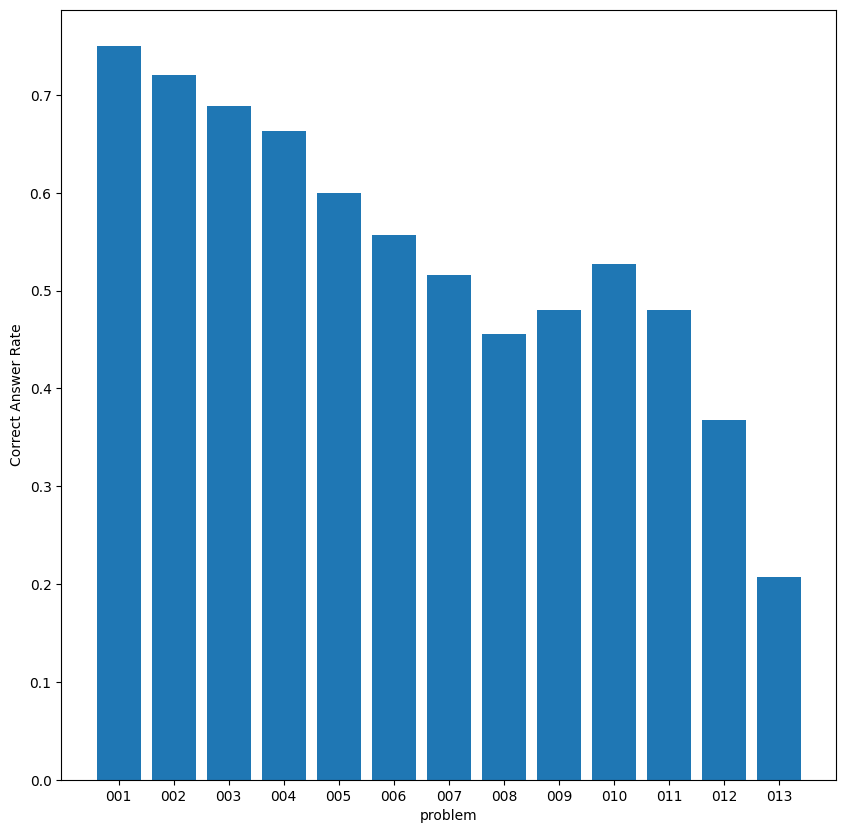

In [50]:
df_problem = df.copy()
df_problem['problem'] = df_problem['assessmentItemID'].str[7:]
fig, ax = plt.subplots(figsize=(10, 10))
problems = df_problem.groupby('problem')['answerCode'].mean()
plt.bar(problems.index, problems)
ax.set_xlabel('problem')
ax.set_ylabel('Correct Answer Rate')

### testcode

In [51]:
#각 testCode 별로 풀어진 횟수 count
df['testCode'].value_counts()

testCode
7    315177
5    306317
1    303675
3    303365
4    300403
2    297263
6    296284
8    271841
9    131631
Name: count, dtype: int64

대체적으로 골고루 문제가 풀어졌으며, 9번에 해당하는 코드만 적게 풀어진 것으로 확인

In [52]:
df_cor = df.copy()
df_cor = df_cor.loc[ : , ['testCode', 'answerCode']]
df_cor.corr()['testCode']['answerCode']

-0.2009546600276782

testCode를 기준으로 groupby 진행

In [53]:
code_groupby = df.groupby('testCode').agg({'answerCode' : percentile, 'assessmentItemID': 'nunique',
                                      'testId' : 'nunique', 'userID': 'nunique', 'KnowledgeTag' : 'nunique'})
code_groupby = code_groupby.reset_index()
code_groupby

,testCode,answerCode,assessmentItemID,testId,userID,KnowledgeTag
0,1,0.801686,975,192,2301,64
1,2,0.738023,1022,194,2481,70
2,3,0.702210,1060,198,2724,85
3,4,0.680256,1031,198,2974,81
4,5,0.659098,1266,193,2577,98
5,6,0.712279,1213,186,2364,93
6,7,0.521761,1322,164,1882,176
7,8,0.500826,1050,138,1693,150
8,9,0.454680,515,74,743,96


[Text(0.5, 1.0, 'Answer Rate by Test Code')]

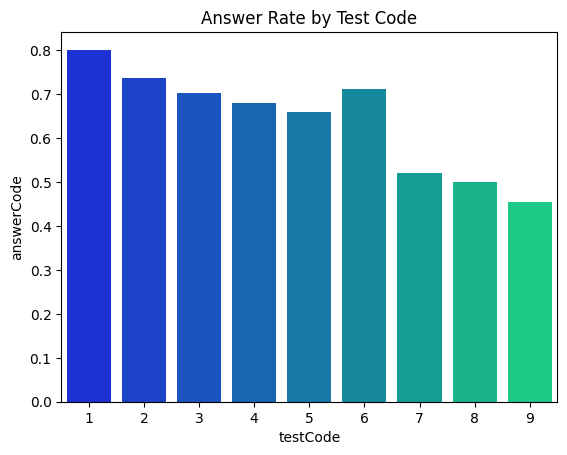

In [54]:
sns.barplot(x='testCode', y='answerCode', data=code_groupby, palette='winter').set(title='Answer Rate by Test Code')

비교적으로 testCode에 따라 선형적으로 정답률이 나옴  
가설 : testCode가 난이도를 의미할 수 있겠다.  
다만, 6의 정답률이 높은 이유에 대한 설명이 필요

좀 더 정확한 분포를 알아보기 위해서 testCode 별 유저의 정답률 분포 확인

In [67]:
user_testcode_groupby = df.groupby(['userID', 'testCode']).agg({'answerCode': 'mean'}).reset_index()   
user_testcode_groupby.rename(columns={'answerCode':'answer_rate'}, inplace=True)                   

<Axes: title={'center': 'Distribution of answer rate of users by testCode'}, xlabel='testCode', ylabel='answer_rate'>

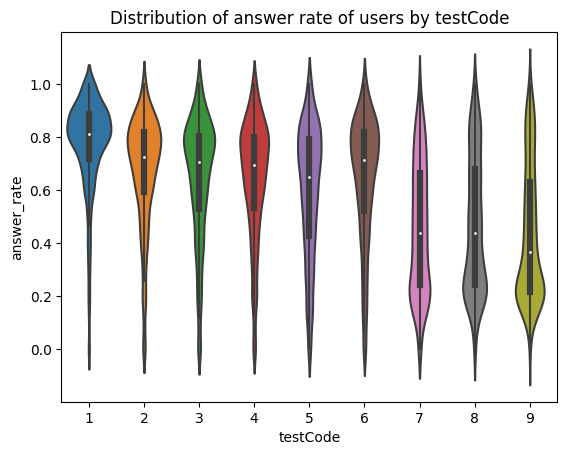

In [71]:
fig, ax = plt.subplots()

ax.set_title("Distribution of answer rate of users by testCode")
sns.violinplot(x="testCode", y="answer_rate", data=user_testcode_groupby.sort_values('testCode'))

위 그래프를 통해서 testCode가 1일 때의 분포와 testCode가 7, 8, 9일 때의 분포가 다른 분포들과 확연한 차이가 있다는 것을 확인 <br>
따라서 testCode 자체를 binning해 볼 수 있을 것 같다는 결론을 내림

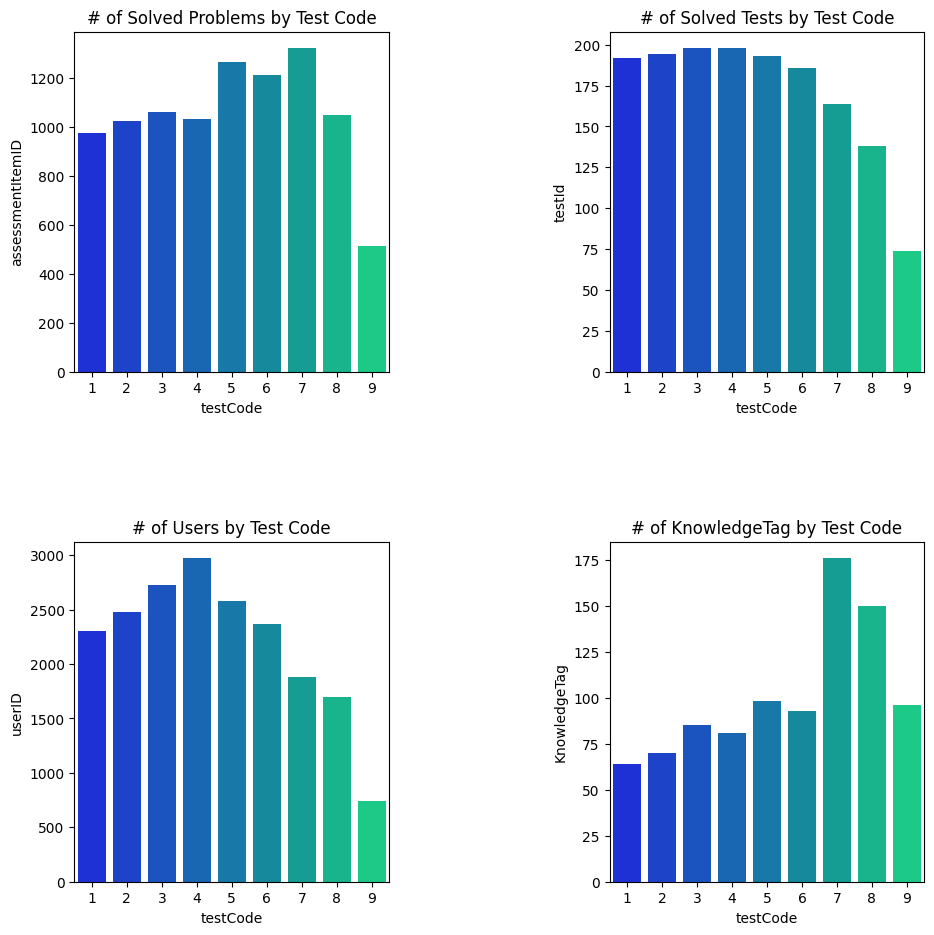

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.barplot(x='testCode', y='assessmentItemID', data=code_groupby, palette='winter', ax=ax1).set(title='# of Solved Problems by Test Code')
sns.barplot(x='testCode', y='testId', data=code_groupby, palette='winter', ax=ax2).set(title='# of Solved Tests by Test Code')
sns.barplot(x='testCode', y='userID', data=code_groupby, palette='winter', ax=ax3).set(title='# of Users by Test Code')
sns.barplot(x='testCode', y='KnowledgeTag', data=code_groupby, palette='winter', ax=ax4).set(title='# of KnowledgeTag by Test Code')

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.5)
plt.show()

일부 학생을 선별하여 푼 문제의 testcode를 체크  
선별 기준:  
1. 푼 문제의 수가 많은 학생, 중간인 학생
2. 정답률이 높은 학생

In [ ]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby

,assessmentItemID,answerCode
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
3,1035,0.692754
4,670,0.694030
...,...,...
7437,16,0.375000
7438,16,0.750000
7439,15,0.733333


In [ ]:
samples = stu_groupby.sort_values(by='assessmentItemID', ascending=False).index[[0, 3300]]
samples

Int64Index([730, 4663], dtype='int64', name='userID')

In [ ]:
sample_df = df[df['userID'] == 730]

lv_sample = sample_df.groupby('testCode').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})
lv_sample

,assessmentItemID,answerCode
testCode,,
4,325,0.483077
5,294,0.829932
7,1241,0.573731


In [ ]:
sample_d2 = df[df['userID'] == 4663]
lv_sample2 = sample_d2.groupby('testCode').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})

lv_sample2

,assessmentItemID,answerCode
testCode,,
5,140,0.578571
6,7,0.571429
7,140,0.842857


In [ ]:
samples2 = stu_groupby.sort_values(by='answerCode', ascending=False).index[[0]]
samples2

Int64Index([7171], dtype='int64', name='userID')

In [ ]:
sample2_df = df[df['userID'] == 7171]
lv_sample3 = sample2_df.groupby('testCode').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})

lv_sample3

,assessmentItemID,answerCode
testCode,,
1,10,1.0
6,10,1.0


세 학생 모두 3개 이하의 testCode만 푼 것을 확인  

제기했던 가설 : testCode가 학년에 따른 분류를 나타낼까?  
다양한 코드를 순서 상관없이 푸는 것으로 보아 학년에 의한 분류는 아닌 것으로 보여진다.

(여기 희원 오빠가 한 거 추가해주면 될 듯!)

## timestamp [현정, 희만, … ]

월별 평균, 총합, 개수

In [ ]:
last_1M = df.groupby([pd.Grouper(freq='1M',key='Timestamp')])["answerCode"].agg(["mean", "sum", "count"])
last_1M

,mean,sum,count
Timestamp,,,
2020-01-31 00:00:00+09:00,0.706736,29449,41669
2020-02-29 00:00:00+09:00,0.686150,60268,87835
2020-03-31 00:00:00+09:00,0.682923,132371,193830
2020-04-30 00:00:00+09:00,0.649782,128931,198422
2020-05-31 00:00:00+09:00,0.643328,131522,204440
2020-06-30 00:00:00+09:00,0.652473,165259,253281
2020-07-31 00:00:00+09:00,0.666436,201425,302242
2020-08-31 00:00:00+09:00,0.657312,231763,352592
2020-09-30 00:00:00+09:00,0.670203,253542,378306


월별로 뽑아낸 데이터의 개수와 정답률

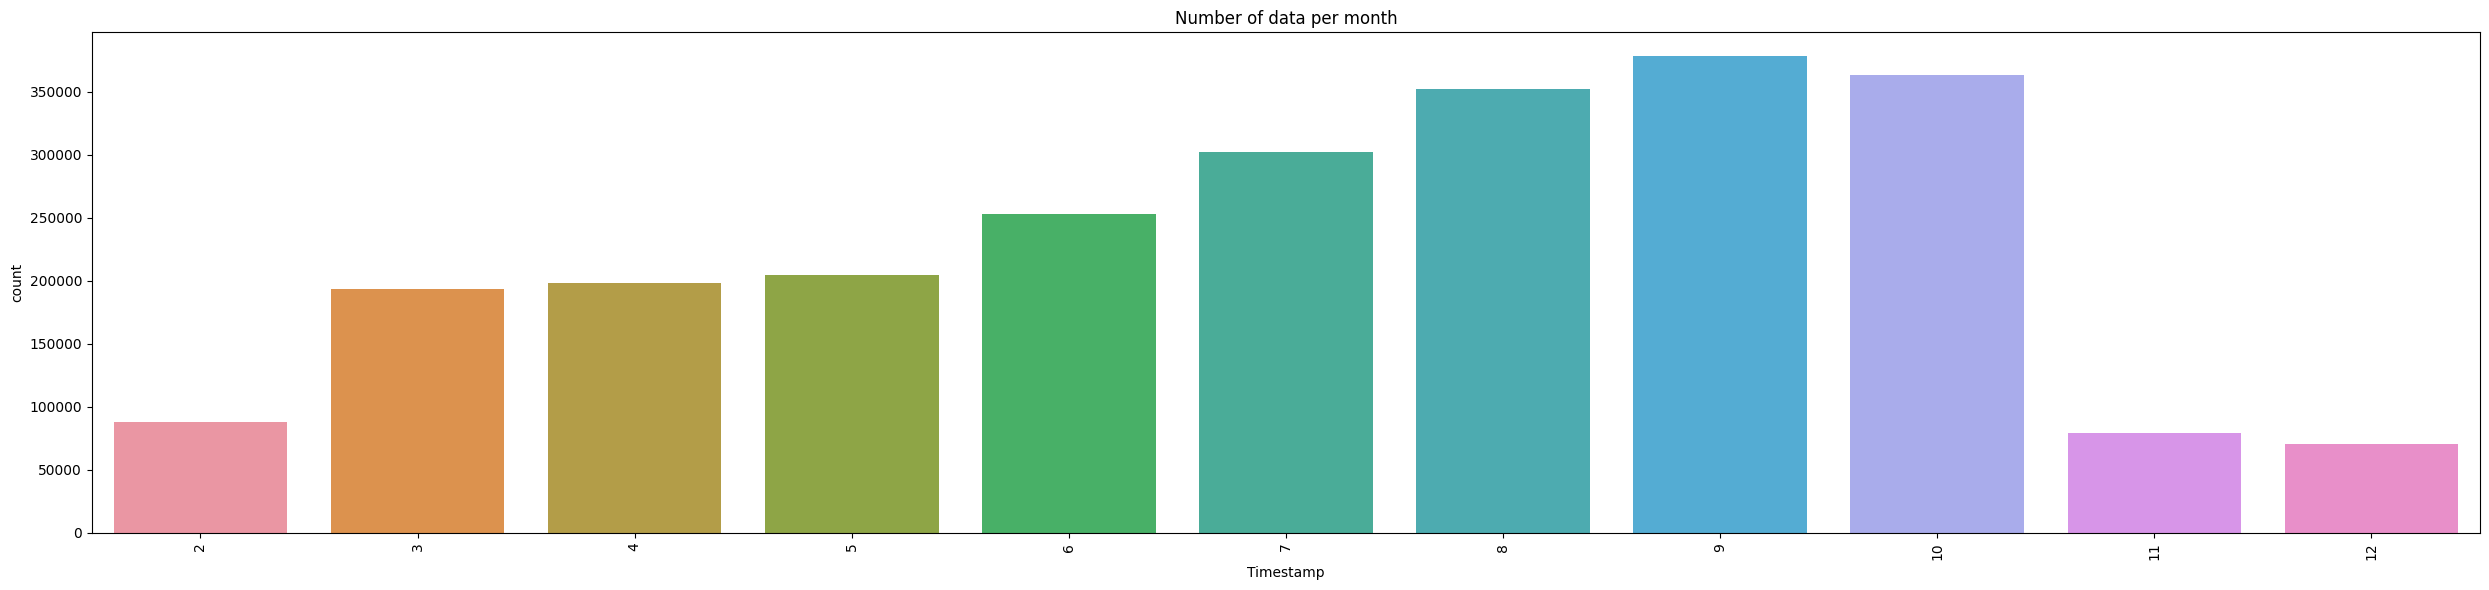

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month , y=last_1M[1:]['count'])
plt.xticks(rotation=90)
plt.title('Number of data per month')
plt.tight_layout()

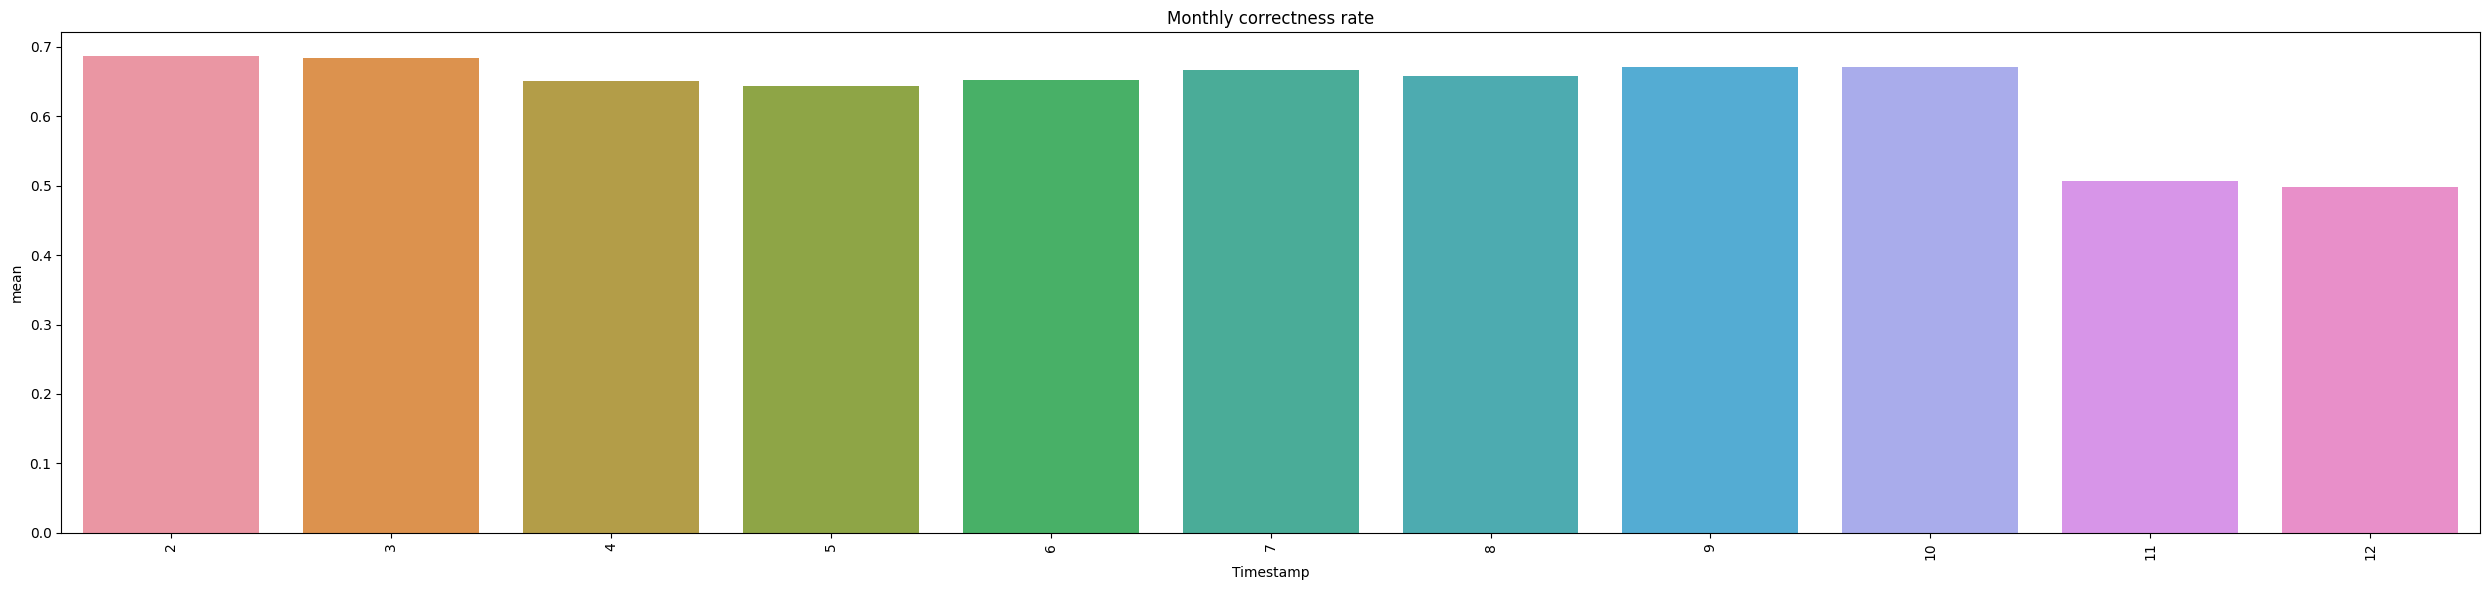

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month, y=last_1M[1:]['mean'])
plt.xticks(rotation=90)
plt.title('Monthly correctness rate')
plt.tight_layout()

시간대별로 추출

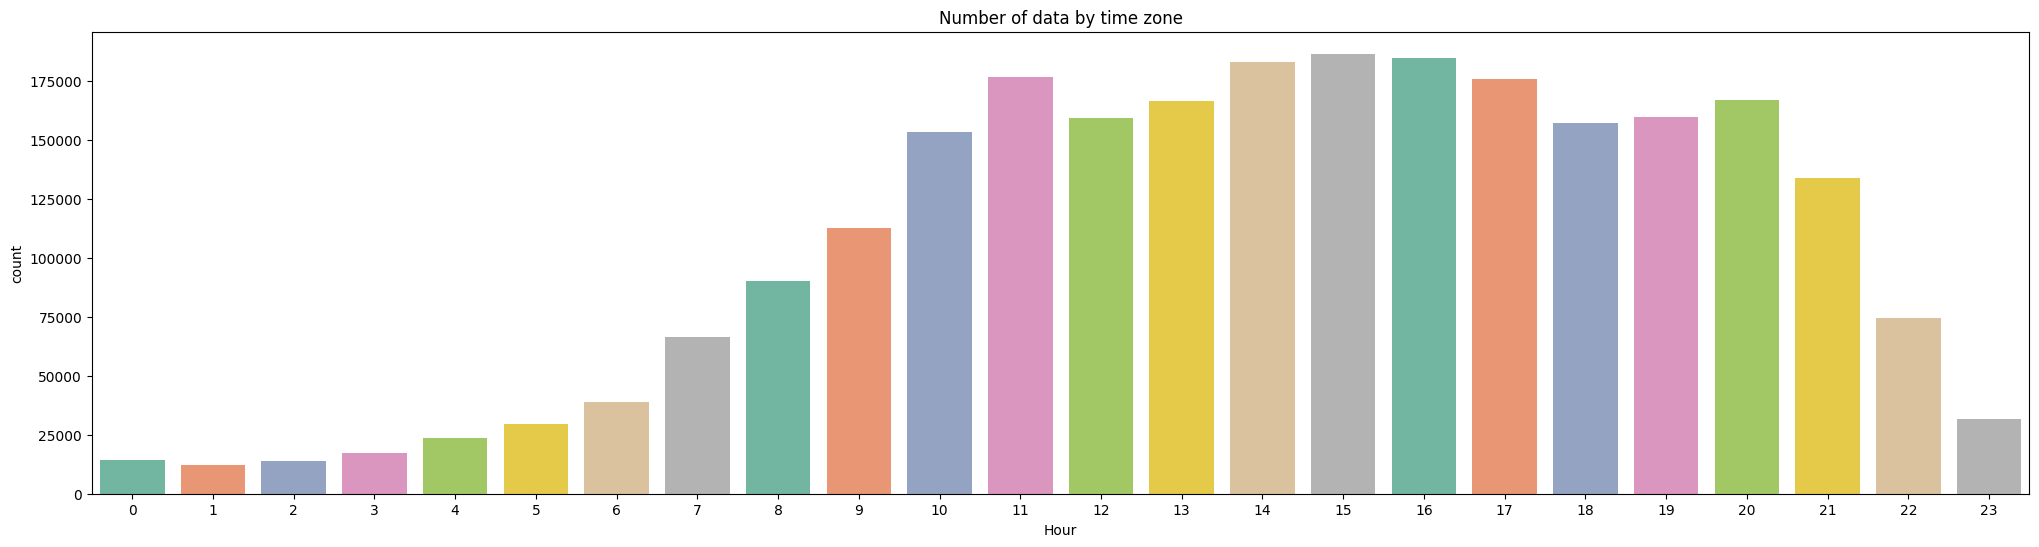

In [ ]:
df['Hour'] = df['Timestamp'].dt.hour 
Hour_ans_rate = df.groupby(["Hour"])["answerCode"].agg(["mean", "count"]).reset_index()

plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="count", data=Hour_ans_rate, palette='Set2')
plt.title('Number of data by time zone')
plt.show()

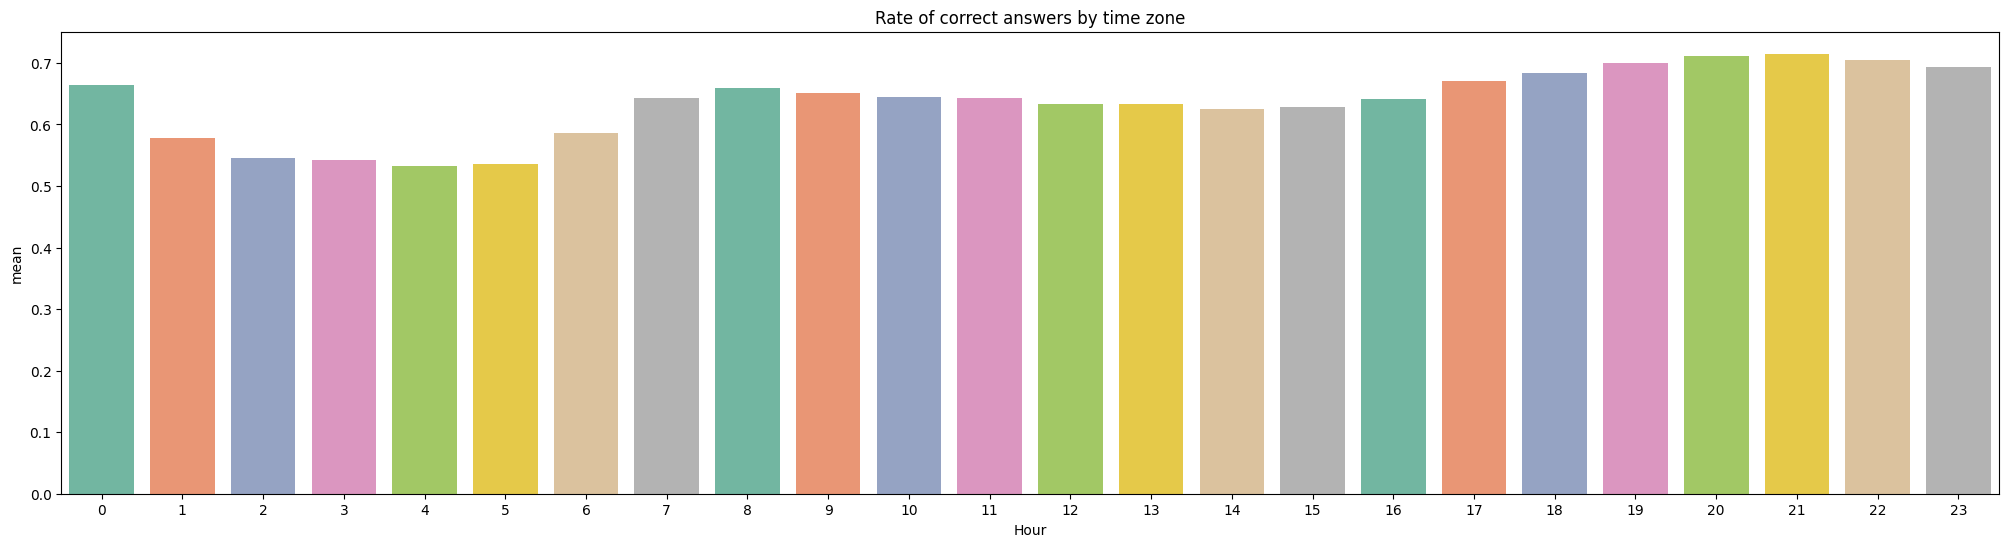

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="mean", data=Hour_ans_rate, palette='Set2')
plt.title('Rate of correct answers by time zone')
plt.show()

시간대별 정답률 확인

In [ ]:
bins = [0, 6, 12, 18, 24]
labels = ['0~5', '6~11', '12~17', '18~23']
df['hour_range'] = pd.cut(df['Hour'], bins=bins, labels=labels, include_lowest=True)

Hour_range_ans_rate = df.groupby(["hour_range"])["answerCode"].agg(["mean", "count"]).reset_index()

새벽시간에 더 적은 문제를 풀었음에도 평균이 상대적으로 낮은것을 확인가능

In [ ]:
Hour_range_ans_rate

,hour_range,mean,count
0,0~5,0.565643,149423
1,6~11,0.644490,757332
2,12~17,0.646343,1053100
3,18~23,0.707137,566101


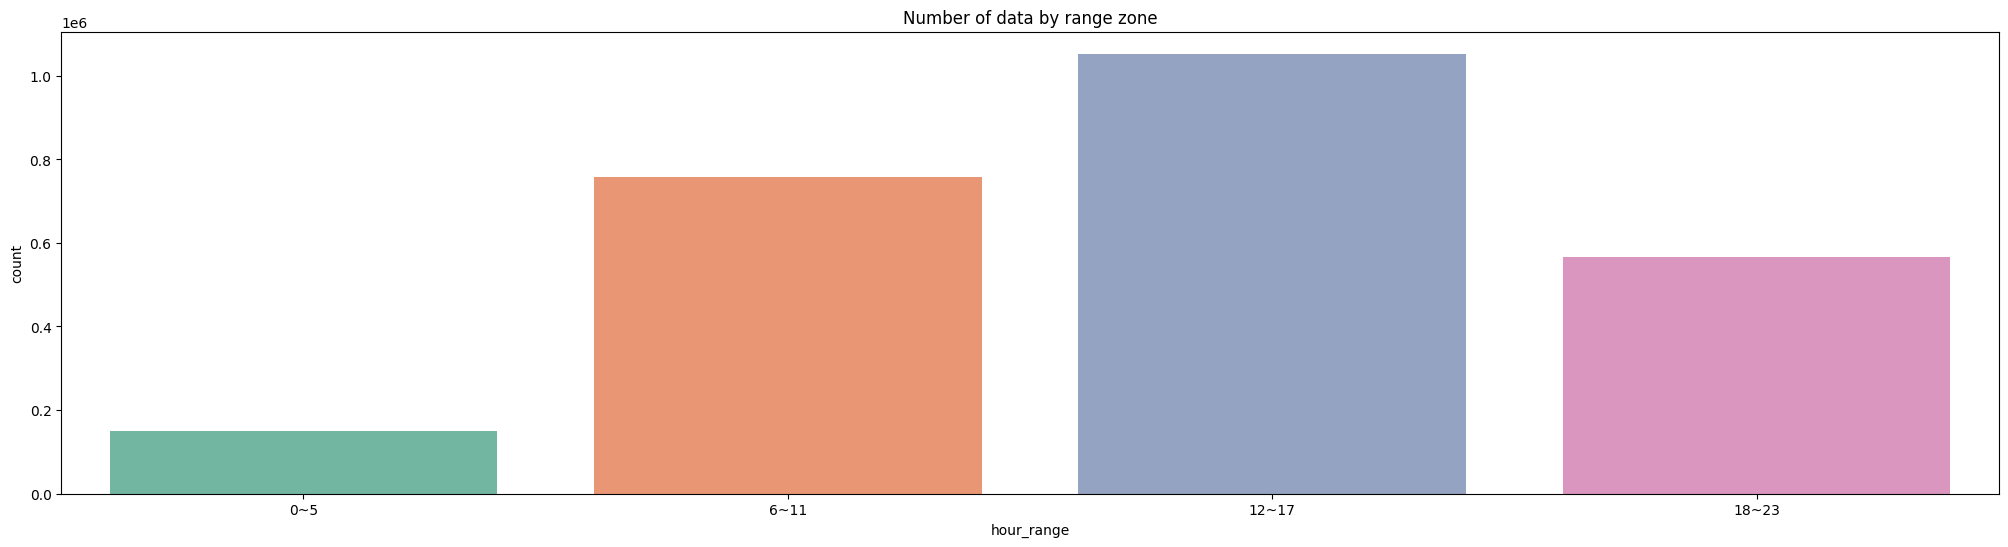

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x="hour_range", y="count", data=Hour_range_ans_rate, palette='Set2')
plt.title('Number of data by range zone')
plt.show()

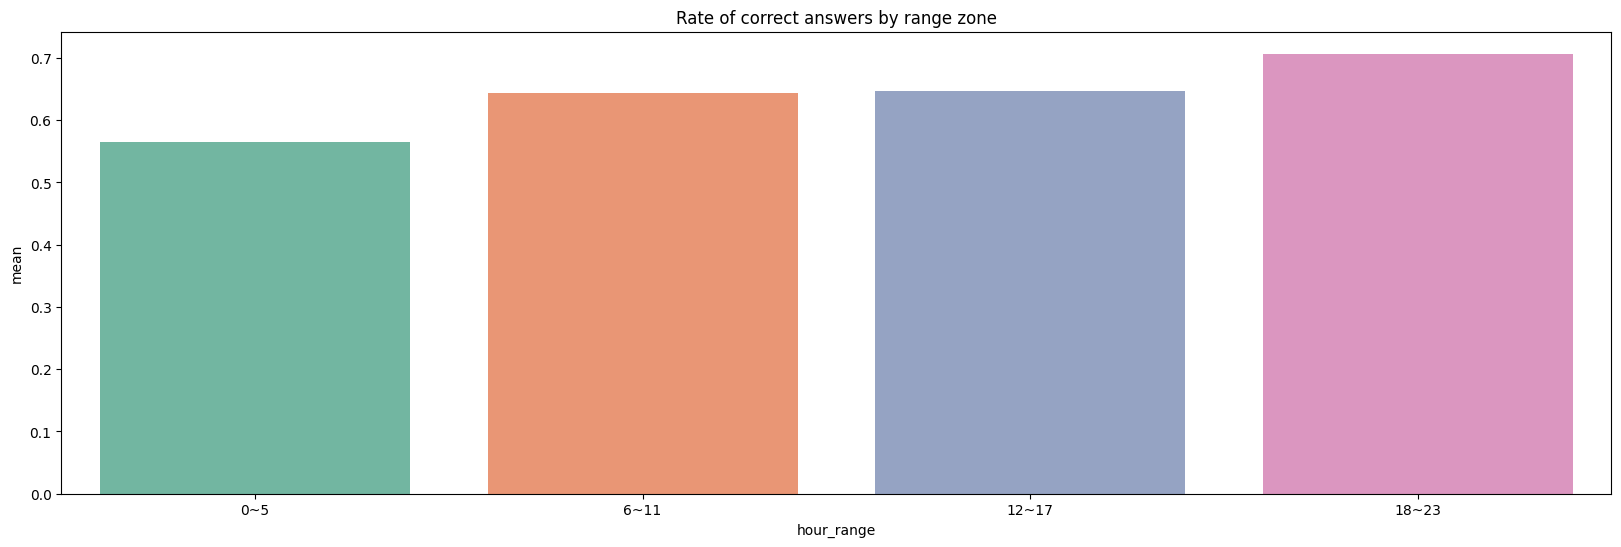

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(x="hour_range", y="mean", data=Hour_range_ans_rate, palette='Set2')
plt.title('Rate of correct answers by range zone')
plt.show()

## knowledgetag

### baseline에서더 많이 노출된 태그가 정답률이 더 높은가?

### knowledgeTag를 1000단위로 나눠서 분류
가설 : 숫자가 가까운 knowledgeTag는 비슷한 유형일 것이다.

In [ ]:
def tag_map(x: int) -> int:
    x = int(x)
    x = x // 1000
    return x

In [ ]:
df_tag = df.copy()

df_tag['KnowledgeTag_cat'] = df_tag['KnowledgeTag'].apply(tag_map)
df_tag

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode,Hour,hour_range,KnowledgeTag_cat
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6,9,6~11,7
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6,9,6~11,7
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6,9,6~11,7
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6,9,6~11,7
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6,9,6~11,7
...,...,...,...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4,16,12~17,2
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4,8,6~11,8
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4,8,6~11,8
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4,8,6~11,8


In [ ]:
df_tag['KnowledgeTag_cat'].nunique()

12

tag에 따른 정답률 분포 확인

In [ ]:
tag_groupby = df_tag.groupby('KnowledgeTag_cat').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby

,userID,answerCode
KnowledgeTag_cat,,
0,440885,0.669835
1,214833,0.650854
2,360487,0.637366
3,88700,0.587542
4,154291,0.466378
5,169576,0.659858
6,118233,0.714462
7,463802,0.747315
8,250094,0.673227


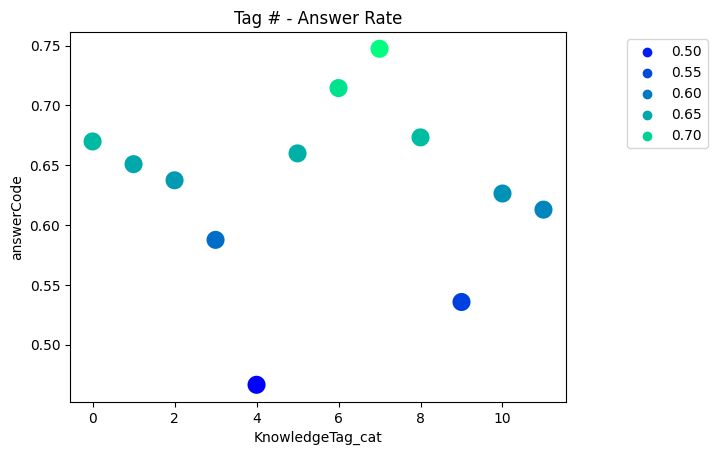

In [ ]:
# tag에 대분류에 따른 정답률 그래프
g = sns.scatterplot(
    data=tag_groupby,
    x='KnowledgeTag_cat',
    y='answerCode',
    s = 200,
    hue = 'answerCode',
    palette = 'winter'
)
ax = plt.gca()
ax.set_title('Tag # - Answer Rate')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

특정 유형 (4)은 비교적 낮은 정답률을, 특정 유형(7)은 비교적 높은 정답률을 보이는 것으로 보여진다.

## testcode + knowledgetag

### KnowledgeTag 별 testCode 개수 확인

In [ ]:
# KnowledgeTag 고유값 추출
know_uni = df.KnowledgeTag.unique()

In [ ]:
# KnowledgeTag 고유값 중에 testcode 여러개 있는 KnowledgeTag 추출
not_know = []
for i in know_uni:
    if len(df[df['KnowledgeTag'] == i].testCode.unique()) != 1:
        not_know.append(i)

In [ ]:
# 오직 7863만 testcode 2개
not_know

[7863]

In [ ]:
df[df['KnowledgeTag'] == 7863].testCode.unique()

array([8, 7])

오직 7863 유형만이 testcode의 중복을 가짐 \
testcode는 난이도가 아니다!

In [ ]:
tag_lv_groupby = df_tag.groupby(['KnowledgeTag_cat', 'testCode'])['answerCode'].apply(percentile)
tag_lv_groupby.sort_index(inplace=True)

tag_lv_groupby

KnowledgeTag_cat  testCode
0                 3           0.697570
                  5           0.658997
                  6           0.679022
                  7           0.565760
                  8           0.579117
                  9           0.475952
1                 3           0.718577
                  6           0.746007
                  7           0.496596
                  8           0.551092
                  9           0.471705
2                 4           0.675058
                  5           0.642791
                  8           0.491956
                  9           0.466955
3                 5           0.615919
                  7           0.517222
                  8           0.596000
4                 7           0.509412
                  8           0.469809
                  9           0.445201
5                 1           0.858432
                  5           0.671061
                  7           0.525278
                  9           0.45519

tag와 testcode 대분류에 따른 정답률 그래프

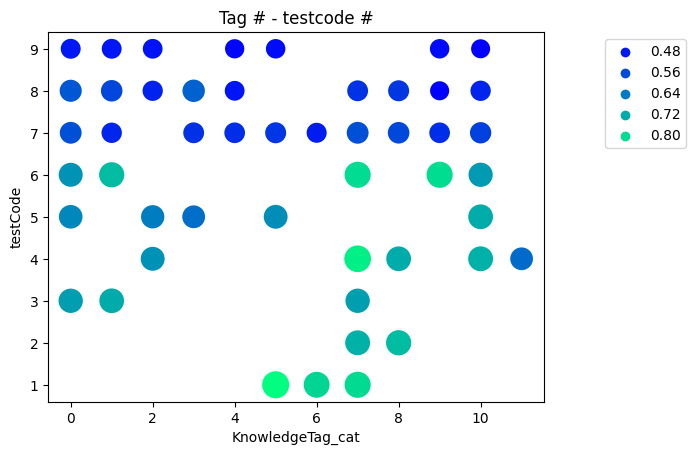

In [ ]:
# 점의 크기 범위 설정
size_range = (10, 500)

# 점의 크기를 정확도 값에 비례하여 계산
point_size = size_range[0] + (size_range[1] - size_range[0]) * tag_lv_groupby

g = sns.scatterplot(
    data=tag_lv_groupby,
    x='KnowledgeTag_cat',
    y='testCode',
    s = point_size,
    hue = tag_lv_groupby,
    palette = 'winter',
    legend = 'brief'
)
ax = plt.gca()
ax.set_title('Tag # - testcode #')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

## 유저별 testcode 확인

In [ ]:
user_uni = df.userID.unique()

In [ ]:
dup_testcode_user = []
max_dup_user = 0
for i in user_uni:
    if len(df[df['userID'] == i].testCode.unique()) > 1:
        max_dup_user = max(max_dup_user, len(df[df['userID'] == i].testCode.unique()))
        dup_testcode_user.append(i)

In [ ]:
len(dup_testcode_user), max_dup_user

(7331, 3)

In [ ]:
dup_testcode = []
for i in user_uni:
    if list(df[df['userID'] == i].testCode.unique()) not in dup_testcode:
        dup_testcode.append(list(df[df['userID'] == i].testCode.unique()))

In [ ]:
len(dup_testcode)

564

In [ ]:
# Counter를 사용하여 중복된 리스트 제거
unique_list = [list(k) for k, _ in Counter(map(tuple, map(sorted, dup_testcode))).items()]

len(unique_list)

129

유저들은 최대 3번의 모든 경우의 수로 testcode를 경험했다.

## 기타

### testcode를 더 크게 범주화

In [ ]:
def big_testcode_map(x:int) -> int:
    x = (x-1) // 3
    return x

In [ ]:
df_bigcode = df.copy()

df_bigcode['bigtestCode'] = df_bigcode['testCode'].apply(big_testcode_map)
df_bigcode

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode,Hour,hour_range,bigtestCode
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6,9,6~11,1
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6,9,6~11,1
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6,9,6~11,1
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6,9,6~11,1
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6,9,6~11,1
...,...,...,...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4,16,12~17,1
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4,8,6~11,1
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4,8,6~11,1
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4,8,6~11,1


In [ ]:
bigcode_groupby = df_bigcode.groupby('bigtestCode').agg({'answerCode' : percentile, 'assessmentItemID': 'nunique'})
bigcode_groupby = bigcode_groupby.reset_index()

bigcode_groupby

,bigtestCode,answerCode,assessmentItemID
0,0,0.747388,3057
1,1,0.683586,3510
2,2,0.501555,2887


[Text(0.5, 1.0, 'Answer Rate by Big Test Code')]

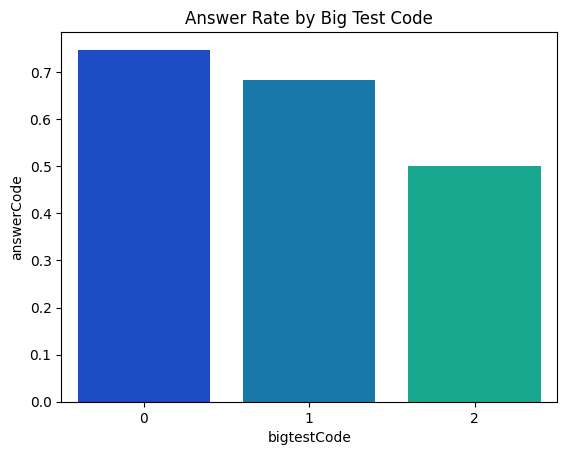

In [ ]:
sns.barplot(x='bigtestCode', y='answerCode', data=bigcode_groupby, palette='winter').set(title='Answer Rate by Big Test Code')

### 문제 번호에 따른 난이도

In [ ]:
df_1 = df.copy()

df_1['item'] = df_1['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호 
# item 열을 int16으로 변경 
df_1["item"] = df_1["item"].astype("int16")

In [ ]:
# test 별로 그룹화 한뒤 각 test 별로 마지막 문항을 나타내는 last_prob_no 피쳐 생성
tmp = df_1.groupby(["testId"]).agg({"item": "max"})
tmp.rename(columns={"item": "last_prob_no"}, inplace=True)

# 기존의 DF와 merge 하여 각각의 시험지의 마지막 문항을 나타내는 피쳐 추가
tmp_df = df_1.copy()
tmp_df = pd.merge(tmp_df, tmp, on="testId", how="left")

# 마지막 문제와 가까운 정도를 계산 
tmp_df["last_prob"] = tmp_df["item"] / tmp_df["last_prob_no"]
tmp_df = tmp_df.drop("last_prob_no", axis=1)
tmp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode,Hour,hour_range,item,last_prob
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6,9,6~11,1,0.142857
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6,9,6~11,2,0.285714
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6,9,6~11,3,0.428571
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6,9,6~11,4,0.571429
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6,9,6~11,5,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4,16,12~17,6,1.000000
2525952,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4,8,6~11,1,0.200000
2525953,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4,8,6~11,2,0.400000
2525954,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4,8,6~11,3,0.600000


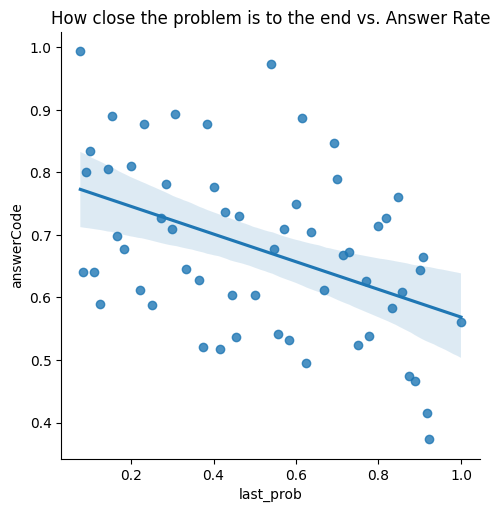

In [ ]:
last_prob_group = tmp_df.groupby("last_prob").agg({"answerCode": "mean"}).reset_index()
sns.lmplot(x="last_prob", y="answerCode", data=last_prob_group)
plt.title('How close the problem is to the end vs. Answer Rate')
plt.show()

last_prob는 해당 문제가 그 시험지의 마지막 문항에 가까운 정도를 나타내는 feature 이다. </br></br>
마지막 문제면 1, 마지막 문제에서 멀어질 수록 0에 가까워진다. </br></br>
해당 그래프에서 알 수 있듯 마지막 문제와 가까워 질수록 정답률이 낮아짐을 알 수 있었다.

### 그래서 우리가 예측해야할 문제의 대부분이 시험지의 마지막 문제인지를 확인

In [ ]:
test_df_1 = pd.read_csv('/opt/ml/input/data/test_data.csv')

# test_df 에서도 last_prob feature 생성
test_df_1['item'] = test_df_1['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호 

test_df_1["item"] = test_df_1["item"].astype("int16")

tmp = test_df_1.groupby(["testId"]).agg({"item": "max"})
tmp.rename(columns={"item": "last_prob_no"}, inplace=True)

tmp_df = test_df_1.copy()
tmp_df = pd.merge(tmp_df, tmp, on="testId", how="left")

tmp_df["last_prob"] = tmp_df["item"] / tmp_df["last_prob_no"]
tmp_df = tmp_df.drop("last_prob_no", axis=1)

In [ ]:
tmp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,item,last_prob
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,1,0.142857
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,2,0.285714
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,3,0.428571
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,4,0.571429
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,6,0.857143
...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,1,0.200000
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,2,0.400000
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,3,0.600000
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,0.800000


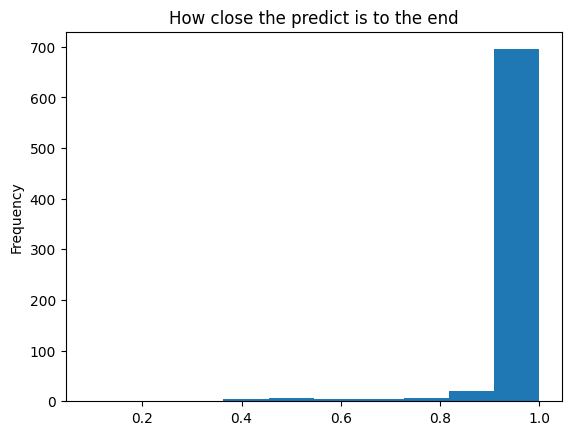

In [ ]:
tmp_df[tmp_df['answerCode'] == -1].last_prob.plot.hist()
plt.title('How close the predict is to the end')
plt.show()

대부분의 예측해야할 문제가 시험지의 마지막임을 알 수 있었다.